# Automatic Creating of Mining Polygons using Herarchical Clustering Techniques

Hierarchical Clustering es una técnica de agrupación de bloques en clusters de acuerdo a medidas de similaridad y disimilaridad. Existen 2 enfoques:

* *Agglomerative Clustering*: Consiste en partir con los clusters a nivel de bloques, e ir agrupando de acuerdo a un criterio de similaridad. Si no hay un criterio de parada, termina cuando cuando todos los bloques se agrupan en 1 cluster.
* *Divisive Clustering*: Consiste en partir con un cluster, e ir dividiendo en 2 de acuerdo a un criterio de disimilaridad. Si no hay un criterio de parada, termina cuando todos los cluster son 1 bloque.

## Índices de similitud

Existen varias medidas de similitud, pero todas comparten algunas reglas básicas (definición de índice de similitud):

* El índice de similitud es un cociente entre medidas de similitud/disimilitud
\begin{equation*}
    \text{I. Similitud} = \frac{\text{Medida Similitud}}{\text{Medida Disimilitud}}
\end{equation*}
Donde las medidas de similitud y disimilitud dependen de ciertos factores, como tipo de roca o distancia, respectivamente.

* Todos los factores de que determinan la similitud o disimilitud están normalizadas.

* Se usa un valor de pensalización (entre 0 y 1) para los factores categóricos (eg. Tipo de roca, Destino, Periodo de extracción) y una distancia de Minkwski (p-norm) para valores numéricos (eg. Distancia, Ley) y se divide por el mayor valor entre todos estos (para normalizar).

## Algoritmo
El pseudocódigo del clustering tendría la siguiente forma:
 ```mermaid
FOR EACH bench IN dataset 
    SimilarityMatrix = Calculate_Similarity_Matrix()
    AdjencyMatrix = Create_Adjency_Matrix()
    NumerOfClusters = NumberOfBlocks
    MaxNumberOfClusters = NumberOfBlocks/AverageDesiredNumberOfBlocksInCluster \\ Opcional

    WHILE NumberOfClusters > MaxNumberOfClusters
        (i,j) = Find_Most_Similar_Adjacent_Clusters(AdjencyMatrix, SimilarityMatrix)
        IF length(Clusters(i)) + length(Clusters(j)) <= MaxClusterLength THEN
            SimilarityMatrix(i,:) = Min(SimilrityMatrix(i,:), SimilarityMatrix(j,:))
            SimilarityMatrix(j,:) = 0
            AdjancencyMatrix(i,:) = Max(AdjancencyMatrix(i,:), AdjancencyMatrix(j,:))
            AdjancencyMatrix(j,:) = 0
            Clusters(i) = Clusters(i) + Clusters(j)
            NumberOfClusters = NumberOfClusters - 1
        ELSE
            AdjacencyMatrix(i,j) = 0
        ENDIF
    ENDWHILE

    SmallClusters = Get_Small_Clusters(Clusters, MinClustersSize)
    Clusters = Explode_Clusters(SmallClusters)

    FOR NumberOfIterations \\(Mientras hayan corner blocks)
        CornerBlocks = Find_Corner_Blocks()
        Modify_Cluster_IDs(CornerBlocks)
        Clusters = Remove_Empty_Clusters(Clusters)
    ENDFOR
ENDFOR
```

Note que cada vez que agrupamos clusters, es necesario actualizar los índices de similaridad. Hay 3 enfoques para calcular la similaridad entre clusters:
* Single Link
* Complete Link
* Average Link

Tabesh y Askari-Nasab, después de probar todos los enfoques, escogió Complete Link, en el cual la similaridad entre dos clusters está determinada por la similaridad mínima entre todos los pares de bloques entre los dos clusters.

## Comentarios de Tabesh y Askari-Nasab de la implementación
Utilizaron 3 casos de estudio para verificar el rendimiento del algoritmo en distintas situaciones
* Mina de oro de 90.000 bloques de 50x50x15 [pies]. Ésta data se usó para comentar acerca del tiempo de procesamiento y recursos necesarios para correr el algoritmo en un modelo de tamaño real. Hay 4 tipos de material: oro, plata, cobre y sulfuro. Los minerales de oro y plata con alta ley son llevados a un molino, mientras que los de oro de baja ley y de cobre de alta ley son llevados a una planta de lixivización.
* El segundo dataset es una pequeña región de la misma mina, de 874 bloques, usada para ilustrar las características del modelo.
* El tercer dataset es una pequeña región de una "oil sands operation" para ilustrar otra implementación de la técnica de clustering. Consiste en 2792 bloques categorizados en 5 materiales distintos.

Se definen 4 medidas de calidad del clustering, definidas en base a los objetivos para los cuales se formaron los clusters.
* La primera medida es de acuerdo al tamaño del cluster. El objetivo es obtener un tamaño acotado y adecuado, pues clusters demasiado grandes o demasiado pequeños no son convenientes para la planificación minera.
* Las otras 3 medidas son respecto a la homogeneidad del tipo de roca, destino de cada bloque y la ley de cada elemento, llamadas rock unity, destination dilution factor, and grade variation in clusters.

**Rock Unity** (RU) se define como la porción más grande del tipo de roca del cluster.

**Destination Dilution Factor** (DDF) es el tonelaje de los bloques que comparten destino dividido entre el total de tonelaje del cluster.

**Coefficient of Variation** (CV) es un parámetro conocido que es calculado dividiendo la desviación estándar de los valores respecto a su media (de la ley de cada bloque). El promedio del CV del mayor elemento de la mina es otra medida de rendimiento que representa la homogeneidad de la ley en los clusters.


### Control del tamaño de los clusters
El clustering se realiza de "abajo hacia arriba" en términos de tamaño, por lo que el tamaño del cluster se puede controlar relativamente fácil. El tamaño de un nuevo cluster se verifica vs el tamaño máximo cada vez que dos clusters son escogidos para ser unidos. Si se viola esta condición, simplemente los clusters no se unen.

Otro mecanismo de control del tamaño es calcular el número total de clusters dividiendo el número total de bloques entre la media de bloques en caad cluster, y terminar el procedimiento de clustering cuando el número de clusters es igual al número deseado de clusters.

También se puede aplicar un criterio de tamaño mínimo de cluster en el postprocesado, de modo de remover los clusters que quedaron de un tamaño menor a cierto umbral (Barca, Rumantir). La implementación de este criterio puede hacer que algún cluster viole el tamaño máximo, al ser un postprocesado.

[Ver qué sucede cuando sólo un bloque es un cluster y sólo tiene 1 vecino de otro clúster]

### Postprocesado
Se implementa una etapa de postprocesado para refinar la forma de los clusters. Se encarga de dos cambios:
* Remover puntas (sharp corners)
* Remover clusters pequeños

El proceso consiste en que, los clusters de tamaño muy pequeño son desagregados en clusters de 1 solo bloque, y se comienza con el refinamiento de formas. Este es un proceso iterativo en el que los bloques que cumplen que tienen menos (o igual) de un bloque adjacente del mismo cluster y más (estricto) de un bloque adjacente de otro cluster, son desprendidos del cluster original y añadidos a aquel con más vecinos. Este proceso se repite hasta que no hayan más bloques corner.


#### Clustering usando sólo distancia como medida de disimilitud
El índice de similaridad, cuando sólo consideramos la distancia como medida de disimilitud se calcula por
\begin{equation*}
    S_{ij} = \frac{1}{\tilde{D}_{ij}}
\end{equation*}

donde $\tilde{D}_{ij}$ es la distancia normalizada entre los bloques $i$ y $j$. De la misma forma puede ser definida una medida de similaridad de acuerdo a sólo la ley de los bloques.

En general, clusterizar de acuerdo a sólo una de estas medidas no es del todo útil considerando el cómo se procesan los clústers en planta.

### Clustering con más medidas de similitud
El índice de similaridad se calcula como
\begin{equation*}
    S_{ij} = \frac{T_{ij}}{\tilde{D}_{ij}^{W_D} \cdot \tilde{G}_{ij}^{W_G}}
\end{equation*}
donde $T_{ij}$ es la penalización aplicada si los bloques $i$ y $j$ no son enviados al mismo destino y $\tilde{G}_{ij}^{W_D}$ es la diferencia normalizada entre las leyes de los bloques $i$ y $j$.

### Directional Mining Units
La clusterización también se puede usar para crear planes de corto plazo de unidades de minería, control y explosión de mineral. Por ello, la forma de los clusters debiese ser consistente con la dirección de minería.

Por ello, también podemos tomar una medida de similaridad de acuerdo con la dirección de minería, tomando en cuenta la distancia de cada bloque de la recta de la dirección de minería, determinado por dos puntos en el plano coordenado ajustados por el usuario como punto inicial y final de minería. Esto puede resultar en clusters perpendiculares a la dirección de minería. El índice de similitud respecto a la dirección de minería es el siguiente

\begin{equation*}
    S_{ij} = \frac{T_{ij}}{\tilde{D}_{ij}^{W_D} \cdot \tilde{G}_{ij}^{W_G} \cdot \tilde{M}_{ij}^{W_M}}
\end{equation*}

donde 
\begin{equation*}
    M_{i} = \text{sign}\left( (M_i^1)^2 - (M_i^2)^2 \right)\sqrt{\left| (M_i^1)^2 - (M_i^2)^2 \right|}
\end{equation*}
$M_i^1$ y $M_i^2$ es la distancia euclideana al punto de inicio y término de la dirección de minería, respectivamente.

Es poco recomendable usar todos los parámetros de similitud, pues sus efectos se pueden contrarrestar. Por ejemplo, se puede usar el destino o bien la ley como parámetros de similitud, pues usualmente están correlacionados.

### Clustering within boundaries
A veces será necesario crear clusters con ciertas restricciones, por necesidades mineras a corto plazo, mine push backs (área designada para minar en una sola operacion) o designación de zonas mineras. Esto se puede logar manipulando la matriz de adyacencia. Esta se puede multiplicar por otra matriz binaria, indicando aquellos bloques que son de la misma región o no. 

Esta idea puede ser útil para añadir una variable temporal al problema, de modo que, por ejemplo, un cluster minado en un periodo i no se puede juntar con un cluster del periodo i+1.

Otra idea de bounder clustering podría ser tener clusters con absoluta distinción entre mineral y estéril. Sin embargo, esto puede llevar a clusters demasiado pequeños o irregulares, dependiendo de la naturaleza del depósito. El postprocesado (refinamiento de formas) permite flexibilizar (ignorar) cotas estrictas para obtener clusters con mejores formas.


## Implementación

### EDA

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import numpy.matlib as matlib
# import gurobipy as gp
# from gurobipy import Model, GRB, quicksum 
import time
# import os
# import io
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors 
import seaborn as sns

In [2]:
mina_df = pd.read_csv('CP_fases.txt', sep="\s+")
mina_df.rename(columns={'0': 'id'}, inplace=True)

mina_df.head()

,x,y,z,au,cpy,cueq,cus,cut,density,material,py,recg_au,recg_cu,tasox,tipomineral,fase,id
0,491425.0,7456205.0,1968.0,0.288929,1.124707,0.712658,0.022003,0.550661,2.615598,8,0.401511,69.001505,87.011938,0.039957,2,4,1
1,491435.0,7456195.0,1968.0,0.266522,1.057851,0.640223,0.021141,0.491924,2.626056,8,0.197908,68.839492,87.471598,0.042976,2,4,2
2,491445.0,7456195.0,1968.0,0.243283,2.427782,0.531022,0.019991,0.396348,2.637350,6,0.399009,68.633711,87.659524,0.050438,2,4,3
3,491455.0,7456195.0,1968.0,0.243283,2.427782,0.531022,0.019991,0.396348,2.637350,6,0.399009,68.633711,87.659524,0.050438,2,4,4
4,491435.0,7456205.0,1968.0,0.288929,1.124707,0.712658,0.022003,0.550661,2.615598,8,0.401511,69.001505,87.011938,0.039957,2,4,5


In [3]:
mina_df.info()
mina_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91282 entries, 0 to 91281
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   x            91282 non-null  float64
 1   y            91282 non-null  float64
 2   z            91282 non-null  float64
 3   au           91282 non-null  float64
 4   cpy          91282 non-null  float64
 5   cueq         91282 non-null  float64
 6   cus          91282 non-null  float64
 7   cut          91282 non-null  float64
 8   density      91282 non-null  float64
 9   material     91282 non-null  int64  
 10  py           91282 non-null  float64
 11  recg_au      91282 non-null  float64
 12  recg_cu      91282 non-null  float64
 13  tasox        91282 non-null  float64
 14  tipomineral  91282 non-null  int64  
 15  fase         91282 non-null  int64  
 16  id           91282 non-null  int64  
dtypes: float64(13), int64(4)
memory usage: 11.8 MB


,x,y,z,au,cpy,cueq,cus,cut,density,material,py,recg_au,recg_cu,tasox,tipomineral,fase,id
count,91282.000000,9.128200e+04,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000
mean,491495.973357,7.456384e+06,2187.059004,0.071752,10.010126,0.196904,0.028348,0.169824,2.493927,2.348502,0.251439,20.471155,25.118488,0.221079,0.910935,2.672871,45641.500000
std,208.751947,2.279014e+02,84.220456,0.083442,29.216819,0.204976,0.045549,0.159794,0.156096,3.589183,0.483646,30.828451,37.775851,0.196674,0.932723,1.125424,26350.987973
min,490965.000000,7.455825e+06,1952.000000,0.000183,0.004594,0.001481,0.000224,0.001481,1.800000,0.000000,0.000000,0.000000,0.000000,0.003291,0.000000,1.000000,1.000000
25%,491345.000000,7.456215e+06,2128.000000,0.016649,0.083105,0.028189,0.005000,0.028189,2.383192,0.000000,0.000000,0.000000,0.000000,0.049170,0.000000,2.000000,22821.250000
50%,491495.000000,7.456385e+06,2208.000000,0.039179,0.348752,0.118358,0.010750,0.118358,2.532500,1.000000,0.000000,0.000000,0.000000,0.168672,1.000000,3.000000,45641.500000
75%,491645.000000,7.456555e+06,2256.000000,0.090219,0.823138,0.309323,0.030120,0.272485,2.626455,5.000000,0.435806,62.872069,78.812326,0.327974,2.000000,4.000000,68461.750000
max,492055.000000,7.456935e+06,2336.000000,1.867645,100.000023,1.446522,0.706230,0.930512,2.728725,82.000000,4.987000,78.284541,90.818887,2.157547,3.000000,4.000000,91282.000000


In [4]:
mina_df.drop(columns=['material', 'au', 'cpy', 'cueq', 'cus', 'py', 'recg_au', 'recg_cu', 'tasox'], inplace=True)

variables_categoricas = mina_df.select_dtypes(include='int64').columns.tolist()
variables_continuas = mina_df.select_dtypes(include='float64').columns.tolist()

print(variables_categoricas)
print(variables_continuas)

['tipomineral', 'fase', 'id']
['x', 'y', 'z', 'cut', 'density']


In [5]:
variables_continuas[3:5]

['cut', 'density']

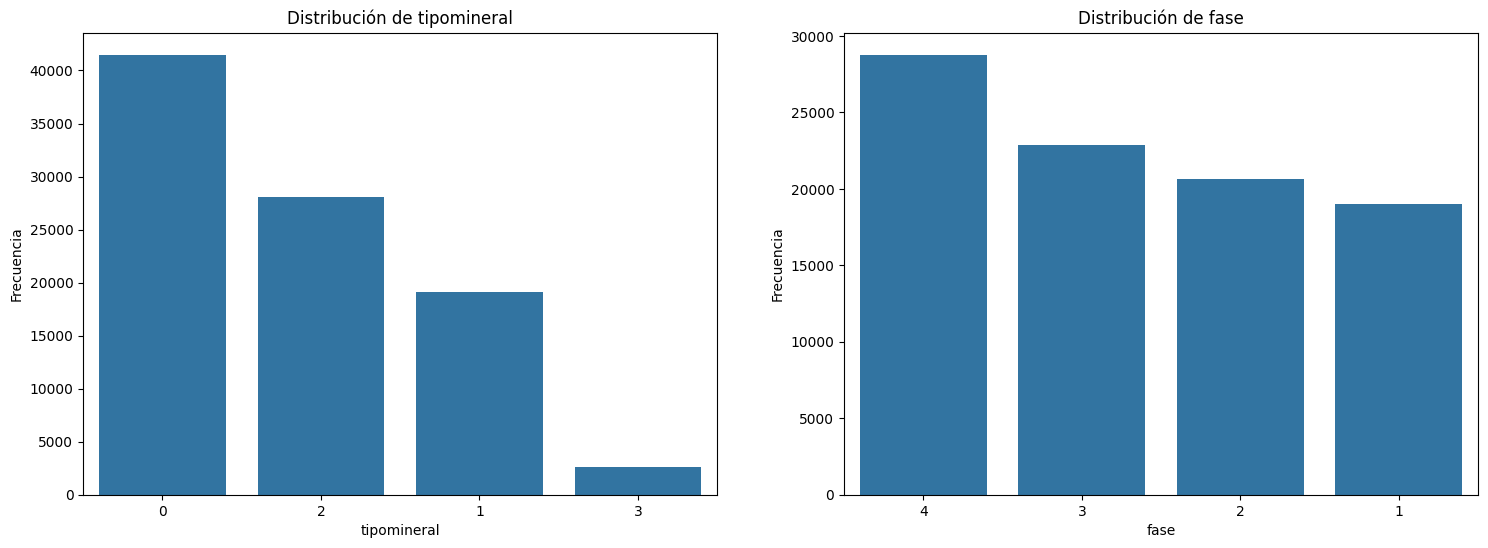

In [6]:
n_cols_int = 2
n_rows_int = 1
fig_int, axes_int = plt.subplots(n_rows_int, 2, figsize=(18,6))
axes_int = axes_int.flatten()

for i, col in enumerate(variables_categoricas[0:2]):
    counts = mina_df[col].value_counts()
    title = f'Distribución de {col}'

    sns.barplot(x=counts.index, y=counts.values, ax=axes_int[i], order=counts.index)
    axes_int[i].set_title(title)
    axes_int[i].set_xlabel(col)
    axes_int[i].set_ylabel('Frecuencia')
    axes_int[i].tick_params(axis='x')

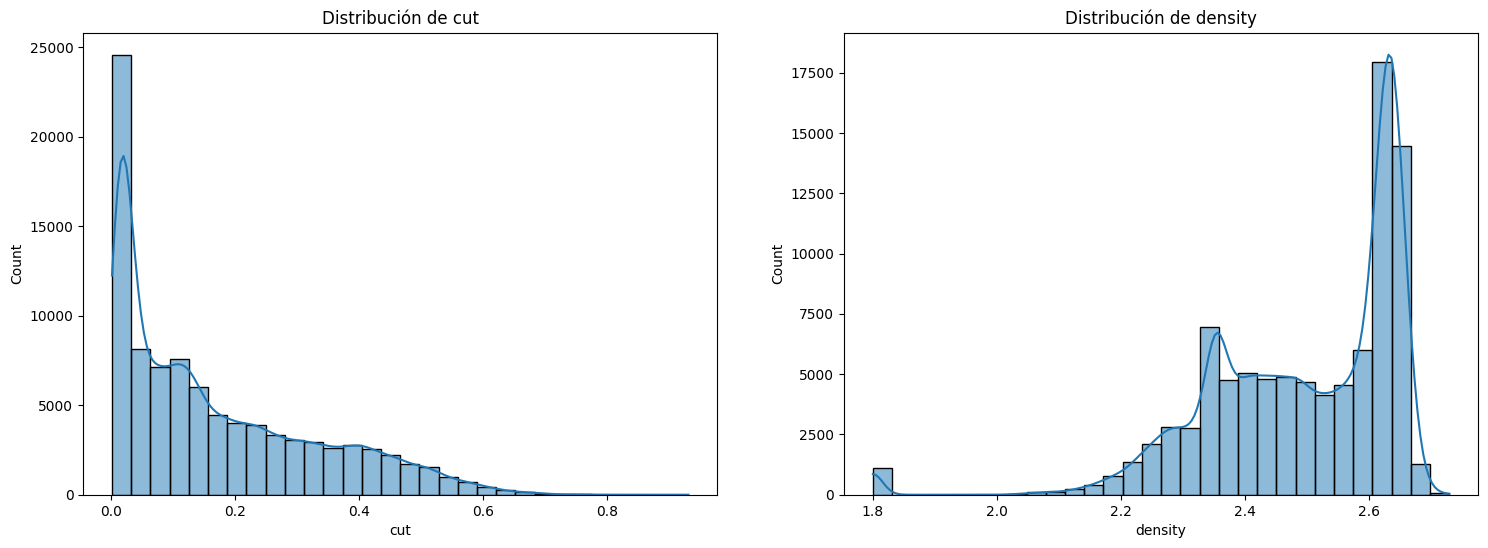

In [7]:
n_cols = 2
n_rows = 1
fig_int, axes_int = plt.subplots(n_rows_int, 2, figsize=(18,6))
axes = axes_int.flatten()

for i, col in enumerate(variables_continuas[3:5]):    
    sns.histplot(mina_df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)


In [8]:
# Fase-Banco de prueba: fase=2, z=2096
fase = 2
z = 2096

filtro = (mina_df['fase'] == fase) & (mina_df['z'] == z)
fase_banco = mina_df[filtro].copy()
fase_banco.reset_index(drop=True, inplace=True)

fase_banco.head()

,x,y,z,cut,density,tipomineral,fase,id
0,491485.0,7456175.0,2096.0,0.366266,2.664827,2,2,11875
1,491495.0,7456165.0,2096.0,0.366266,2.664827,2,2,11897
2,491505.0,7456165.0,2096.0,0.361008,2.635160,2,2,11898
3,491495.0,7456175.0,2096.0,0.366266,2.664827,2,2,11900
4,491505.0,7456175.0,2096.0,0.361008,2.635160,2,2,11901


In [ ]:
# Definición de la función para graficar una fase banco
def plot_fase_banco(FaseBanco, column_hue='cut', cmap='plasma', show_block_label=True, show_grid=True, xsize = 10, ysize = 10, highlight_blocks=[], points=[], arrows=[], sectors=[]):
    if FaseBanco.empty:
        print("El DataFrame 'FaseBanco' está vacío. No se puede graficar.")
        return
    
    fig, ax = plt.subplots(figsize=(xsize, ysize), dpi=100)
    norm = None
    colormap = None
    color_map_discrete = {}
    variables_continuas = FaseBanco.select_dtypes(include='float64').columns.tolist()
    
    fase = FaseBanco['fase'][0]
    z = FaseBanco['z'][0]

    col_data = FaseBanco[column_hue]
    if column_hue in variables_continuas:
        is_continuous = True
    else:
        is_continuous = False
    
    if is_continuous:
        vmin = np.min(col_data)
        vmax = np.max(col_data)
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        colormap = plt.get_cmap(cmap)
    else:
        if len(col_data.unique())<=20:
            colors = plt.get_cmap('tab20', len(col_data.unique()))
            color_map_discrete = {val: colors(i) for i, val in enumerate(col_data.unique())}
        else:
            colors = plt.get_cmap(cmap, len(col_data.unique()))
            color_map_discrete = {val: colors(i) for i, val in enumerate(col_data.unique())}

    for i, row in FaseBanco.iterrows():
        x_center = row['x']
        y_center = row['y']
        block_value = row[column_hue]
        block_width = 10
        block_height = 10

        x_corner = x_center - block_width / 2
        y_corner = y_center - block_height / 2

        if is_continuous:
            color = colormap(norm(block_value))
        else:
            color = color_map_discrete.get(block_value, 'gray')
        
        rect = patches.Rectangle((x_corner, y_corner), block_width, block_height, linewidth=0.5, edgecolor='black', facecolor=color)
        ax.add_patch(rect)
        if show_block_label:
            if is_continuous:
                block_value = np.trunc(block_value*10)/10
            else:
                block_value = int(block_value)
            ax.text(x_center, y_center, str(block_value), ha='center', va='center', fontsize=8, color='black')
    
    if is_continuous:
        x_min = FaseBanco['x'].min() - 5*block_width
        x_max = FaseBanco['x'].max() + 5*block_width
        ax.set_xlim(x_min, x_max)
    else:
        x_min = FaseBanco['x'].min() - 5*block_width
        x_max = FaseBanco['x'].max() + 5*block_width
        ax.set_xlim(x_min, x_max)
    y_min = FaseBanco['y'].min() - 5*block_height
    y_max = FaseBanco['y'].max() + 5*block_height
    ax.set_ylim(y_min, y_max)

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Fase {fase} - Banco (Z={z}) - {column_hue}')
    ax.grid(show_grid, color='gray', linestyle='--', linewidth=0.5)


    for block in highlight_blocks:
        ax.plot(FaseBanco['x'][block], FaseBanco['y'][block], 'ro', markersize=10)

    for p in points:
        ax.plot(p[0], p[1], 'bo', markersize=5)

    for a in arrows:
        P1, P2 = a
        ax.annotate('DM', xy=P2, xytext=P1, arrowprops=dict(arrowstyle='->', color='blue', lw=2, mutation_scale=15))
    
    sector_count = 1
    for s in sectors:
        P1, P2, P3, P4 = s
        center = ( (P1[0]+P3[0])/2, (P1[1]+P3[1])/2 )
        ax.annotate('', xy=P2, xytext=P1, arrowprops=dict(arrowstyle='-', color='black', lw=2, mutation_scale=5))
        ax.annotate('', xy=P3, xytext=P2, arrowprops=dict(arrowstyle='-', color='black', lw=2, mutation_scale=5))
        ax.annotate('', xy=P4, xytext=P3, arrowprops=dict(arrowstyle='-', color='black', lw=2, mutation_scale=5))
        ax.annotate('', xy=P1, xytext=P4, arrowprops=dict(arrowstyle='-', color='black', lw=2, mutation_scale=5))
        ax.annotate(str(sector_count), xy=center, color='black', fontsize=32)
        sector_count+=1
    
    if is_continuous:
        sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.8, aspect=20)
        cbar.set_label(column_hue, rotation=270, labelpad=15)
    else:
        legend_patches = [patches.Patch(color=color, label=str(value)) for value, color in color_map_discrete.items()]
        ax.legend(handles=legend_patches, title=column_hue, loc='upper right', fontsize=8, title_fontsize=10)
    plt.tight_layout()
    plt.show()

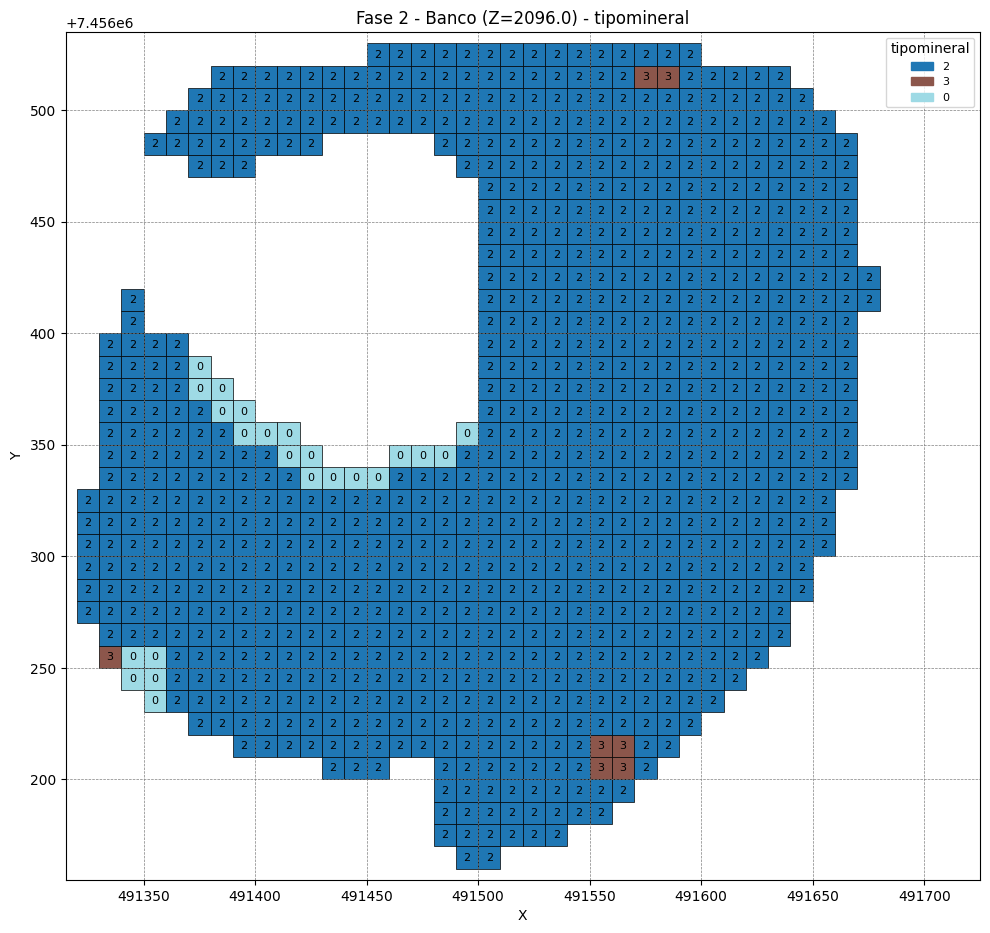

In [10]:
plot_fase_banco(fase_banco, column_hue='tipomineral')

### Implementación del algoritmo

In [ ]:
# Definición de funciones. Incluye Clusterización y Shape Refinement de Tabesh
def Calculate_Adjency_Matrix(FaseBanco, BlockWidth, Sectores=[]):
    '''
    Crea la matriz de adyacencia de los bloques de la fase-banco respecto a sus coordenadas x e y.
    Devuelve una matriz sparse (CSR).
    '''
    x = FaseBanco['x'].values
    y = FaseBanco['y'].values

    X1 = matlib.repmat(x.reshape(len(x),1), 1, len(x))
    X2 = X1.T
    Y1 = matlib.repmat(y.reshape(len(y),1), 1, len(y))
    Y2 = Y1.T

    D = np.sqrt((X1 - X2)**2 + (Y1 - Y2)**2)

    adjency_matrix = (D <= BlockWidth) & (D > 0)
    adjency_matrix = sp.sparse.csr_matrix(adjency_matrix).astype(int)

    if Sectores:
        fase_banco = FaseBanco.copy()
        fase_banco['sector'] = 0
        sector_counter = 1

        n = len(fase_banco)
        sector_matrix = np.zeros((n,n), dtype=int)
        for sector in Sectores:
            mask = ( ((fase_banco['x'] > sector[0][0])*(fase_banco['y'] > sector[0][1]))*((fase_banco['x'] < sector[1][0])*(fase_banco['y'] > sector[1][1]))*((fase_banco['x'] < sector[2][0])*(fase_banco['y'] < sector[2][1]))*((fase_banco['x'] > sector[3][0])*(fase_banco['y'] < sector[3][1])) ) == True
            idx = fase_banco.loc[mask].index
            fase_banco.loc[idx, 'sector'] = sector_counter
            sector_counter += 1
            for i in idx:
                row = np.zeros(n)
                row[idx] = 1
                sector_matrix[i,:] = row

        idx = fase_banco.loc[fase_banco['sector']==0].index
        for i in idx:
            row = np.zeros(n)
            row[idx] = 1
            sector_matrix[i,:] = row
        
        adjency_matrix = Hadamard_Product_Sparse(adjency_matrix, sector_matrix)
        adjency_matrix.eliminate_zeros()
        return adjency_matrix, fase_banco, sector_matrix
    else:
        return adjency_matrix

def Calculate_Similarity_Matrix(
        FaseBanco, 
        peso_distancia = 2, 
        peso_ley = 1, 
        penalizacion_destino = 0.9, 
        penalizacion_roca = 0.9,
        peso_directional_mining = 0.25,
        tol_ley = 0.01,
        tol_directional_mining = 0.01,
        P_inicio = (-1,-1),
        P_final = (1,1)
        ):
    '''
    Calcula la similaridad entre los bloques de la fase-banco, de acuerdo a distancia, ley o destino.
    No es recomendable que todos los criterios de similaridad sean True y, a su vez, al menos uno de ellos debe ser True.
    Devuelve una matriz densa.
    '''

    n = len(FaseBanco)

    similarity_matrix = np.zeros((n, n), dtype=float)

    x = FaseBanco['x'].values
    y = FaseBanco['y'].values

    # Distancia
    X1 = matlib.repmat(x.reshape(len(x),1), 1, len(x))
    X2 = X1.T
    Y1 = matlib.repmat(y.reshape(len(y),1), 1, len(y))
    Y2 = Y1.T

    D = np.sqrt((X1 - X2)**2 + (Y1 - Y2)**2)

    ND = D / np.max(D)

    # Ley
    g = FaseBanco['cut'].values
    G1 = matlib.repmat(g.reshape(len(g),1), 1, len(g))
    G2 = G1.T

    G = np.maximum(np.abs(G1 - G2), tol_ley)

    NG = G / np.max(G)

    # Destino
    t = FaseBanco['destino'].values
    T1 = matlib.repmat(t.reshape(len(t),1), 1, len(t))
    T2 = T1.T
    T = T1 != T2

    T = np.ones((n,n)) - (1-penalizacion_destino)*T*np.ones((n,n))

    # Tipo Roca/Material
    rock = FaseBanco['tipomineral'].values
    R1 = matlib.repmat(rock.reshape(len(rock),1), 1, len(rock))
    R2 = R1.T
    R = R1 != R2

    R = np.ones((n,n)) - (1-penalizacion_roca)*R*np.ones((n,n))

    # Dirección de minería
    M1 = (X1 - P_inicio[0])**2 + (Y1 - P_inicio[1])**2
    M2 = (X1 - P_final[0])**2 + (Y1 - P_final[1])**2
    Mi = np.multiply( np.sign( M1 - M2 ), np.sqrt( np.abs(M1 - M2 )) )
    DM = np.maximum(np.abs(Mi - Mi.T), tol_directional_mining)

    NDM = DM / np.max(DM)

    numerator = np.multiply(R,T)
    denominator = np.multiply(ND**peso_distancia, NG**peso_ley)
    denominator = np.multiply(denominator, NDM**peso_directional_mining)
    similarity_matrix = np.divide(numerator,  denominator, where=np.ones((n,n)) - np.diag(np.ones(n))==1)
    return similarity_matrix

def Hadamard_Product_Sparse(A, B):
    '''
    Calcula el producto de Hadamard (componente a componente) entre una matriz sparse (A) y una densa (B).
    Devuelve una matriz sparse (CSR).
    '''
    rows, cols = A.nonzero()
    data = []
    res_row = []
    res_col = []

    for i in range(len(rows)):
        row = rows[i]
        col = cols[i]
        data.append(A[row, col] * B[row, col])
        res_row.append(row)
        res_col.append(col)
    resultado_sparse = sp.sparse.csr_matrix((data, (res_row, res_col)), shape=A.shape)
    resultado_sparse.eliminate_zeros()
    return resultado_sparse


def Find_Most_Similar_Adjacent_Clusters(AdjencyMatrix, SimilarityMatrix):
    '''
    Encuentra los dos clusters adyacentes más similares entre sí, de acuerdo a la matriz de similaridad y la matriz de adyacencia.
    Devuelve una lista con los índices de los clusters más similares. Si no encuentra pares similares, devuelve None.
    Depende de la función Hadamard_Product_Sparse.
    '''
    Sim_Matrix = Hadamard_Product_Sparse(AdjencyMatrix, SimilarityMatrix)
    Sim_Matrix.eliminate_zeros()
    if Sim_Matrix.nnz == 0:
        return None
    Sim_Matrix = Sim_Matrix.tocoo()
    index_max_similarity = np.argmax(Sim_Matrix.data)
    row_max = Sim_Matrix.row[index_max_similarity]
    col_max = Sim_Matrix.col[index_max_similarity]
    
    if row_max < col_max:
        i = row_max
        j = col_max
    else:
        i = col_max
        j = row_max
    return [i, j]


def Find_Corner_Blocks_Tabesh(FaseBanco, AdjencyMatrix):
    '''
    Encuentra los bloques esquinas de la fase-banco. Utiliza el criterio de Tabesh (2013) para definir los bloques esquinas.
    Devuelve un diccionario cuyas llaves son los bloques esquina y cuyos valores son los clusters con los que es vecino.
    '''
    n = len(FaseBanco)
    corner_blocks = {}
    rows, cols = AdjencyMatrix.nonzero()
    for i in range(n):
        Mismo_Cluster = 0
        Distinto_Cluster = 0
        Clusters_Vecinos = []
        i_is_row = np.where(rows == i)[0]
        for j in i_is_row:
            if FaseBanco.iloc[i]['cluster'] == FaseBanco.iloc[cols[j]]['cluster']:
                Mismo_Cluster += 1
            else:
                Distinto_Cluster += 1
                Clusters_Vecinos.append(FaseBanco.iloc[cols[j]]['cluster'].astype(int))
        
        if (Mismo_Cluster <= 1 and Distinto_Cluster > 1 and (len(np.unique(Clusters_Vecinos)) < len(Clusters_Vecinos))):
            corner_blocks.update({i: np.sort(Clusters_Vecinos)})
    return corner_blocks
    

def Clustering_Tabesh(
        FaseBanco,
        AdjencyMatrix,
        SimilarityMatrix,
        Average_Desired_Length_Cluster = 30, 
        Max_Cluster_Length = 35, 
        Reset_Clusters_Index = True,
        Debug = False
        ):
    '''
    Realiza un clustering jerárquico y agregativo de la fase-banco.
    Average_Desired_Length_Cluster y Max_Cluster_Length son restricciones del tamaño de los clusters.
    Depende de la funcion Find_Most_Similar_Adjacent_Clusters.
    Devuelve un DataFrame de la fase-banco incluyendo una nueva columna llamada 'cluster' que indica el cluster al que pertenece cada bloque.
    '''
    fase_banco = FaseBanco.copy()
    adj_matrix_sparse = AdjencyMatrix
    sim_matrix = SimilarityMatrix
    execution_time = 0
    if Debug:
        print(f'Nonzero entries of Adjency Matrix: {AdjencyMatrix.nnz}')
        tries = 0

    N_Clusters = len(fase_banco)
    n = N_Clusters
    Max_N_Clusters = N_Clusters // Average_Desired_Length_Cluster

    fase_banco['cluster'] = np.arange(N_Clusters).astype(int)
    Clusters_Eliminados = 0
    t1 = time.time()
    while N_Clusters > Max_N_Clusters:
        t1_fmsac = time.time()
        C = Find_Most_Similar_Adjacent_Clusters(adj_matrix_sparse, sim_matrix)
        t2_fmsac = time.time()
        
        if Debug:
            tries += 1
            print(f'Try: {tries}, time: {t2_fmsac-t1_fmsac}')
        if C is None:
            break
        (i,j) = C
        cluster_i = fase_banco[fase_banco['cluster'] == fase_banco.iloc[i]['cluster']]
        cluster_j = fase_banco[fase_banco['cluster'] == fase_banco.iloc[j]['cluster']]

        if len(cluster_i) + len(cluster_j) <= Max_Cluster_Length:
            sim_matrix[i,:] = np.min([sim_matrix[i,:], sim_matrix[j,:]], axis=0)
            sim_matrix[:,i] = np.min([sim_matrix[:,i], sim_matrix[:,j]], axis=0)
            sim_matrix[j,:] = np.zeros(n)
            sim_matrix[:,j] = np.zeros(n)

            adj_matrix_sparse = adj_matrix_sparse.tolil()
            adj_matrix_sparse[i,:] = adj_matrix_sparse[i,:].maximum(adj_matrix_sparse[j,:])
            adj_matrix_sparse[:,i] = adj_matrix_sparse[:,i].maximum(adj_matrix_sparse[:,j])
            adj_matrix_sparse[j,:] = np.zeros(n)
            adj_matrix_sparse[:,j] = np.zeros(n)
            adj_matrix_sparse = adj_matrix_sparse.tocsr()
            adj_matrix_sparse.eliminate_zeros()

            fase_banco.loc[fase_banco['cluster'] == fase_banco.iloc[j]['cluster'], 'cluster'] = fase_banco.iloc[i]['cluster'].astype(int)
            N_Clusters -= 1
            Clusters_Eliminados += 1
        else:
            adj_matrix_sparse[i,j] = 0
            adj_matrix_sparse[j,i] = 0
            sim_matrix[i,j] = 0
            sim_matrix[j,i] = 0
            adj_matrix_sparse.eliminate_zeros()

    t2 = time.time()
    execution_time = t2 - t1
    N_Clusters = len(fase_banco['cluster'].unique())
    if Reset_Clusters_Index:
        fase_banco['cluster'] = fase_banco['cluster'].map(lambda x: np.array(range(1,N_Clusters+1))[np.where(fase_banco['cluster'].unique() == x)[0][0]] if x in fase_banco['cluster'].unique() else x)
    print(f"========PreProcessing Results========")
    print(f"Tamaño Fase-Banco: {n}")
    print(f"Clusters objetivo: {Max_N_Clusters}")
    print(f"Clusters eliminados: {Clusters_Eliminados}")
    print(f"Total de clusters: {N_Clusters}")
    print(f'Tiempo: {execution_time}')

    return fase_banco, execution_time, N_Clusters


### Shape Refinement

In [ ]:
# Shape Refinement, incluyendo mod con otros tipos de Corner aparte de los definidos por Tabesh

def Shape_Refinement_Tabesh(FaseBanco, AdjencyMatrix, Min_Cluster_Length = 10, Iterations_PostProcessing=5, Reset_Clusters_Index=False):
    fase_banco = FaseBanco.copy()
    execution_time = 0
    ID_Small_Clusters = fase_banco['cluster'].value_counts().loc[fase_banco['cluster'].value_counts() < Min_Cluster_Length].index.tolist()
    max_i_cluster = fase_banco['cluster'].max() + 1
    t1 = time.time()
    for i in ID_Small_Clusters:
        blocks = fase_banco.loc[fase_banco['cluster'] == i, 'cluster'].index
        for j in blocks:
            fase_banco.loc[j, 'cluster'] = max_i_cluster
            max_i_cluster += 1

    for iterations in range(Iterations_PostProcessing):
        Corner_Blocks = Find_Corner_Blocks_Tabesh(fase_banco, AdjencyMatrix)
        
        if len(Corner_Blocks) == 0:
            break
        for i in Corner_Blocks.keys():
            if len(Corner_Blocks[i]) == 2:
                Cluster_to_insert = Corner_Blocks[i][0]
            else:
                Cluster_to_insert = np.unique_counts(Corner_Blocks[i]).values[np.unique_counts(Corner_Blocks[i]).counts.argmax()]
            fase_banco.loc[i, 'cluster'] = Cluster_to_insert
    t2 = time.time()
    execution_time = t2-t1
    N_Clusters = len(fase_banco['cluster'].unique())
    if Reset_Clusters_Index:
        fase_banco['cluster'] = fase_banco['cluster'].map(lambda x: np.array(range(1,N_Clusters+1))[np.where(fase_banco['cluster'].unique() == x)[0][0]] if x in fase_banco['cluster'].unique() else x)

    print(f"========PostProcessing Results========")
    print(f"Total de clusters: {N_Clusters}")
    print(f'Tiempo: {execution_time}')

    return fase_banco, execution_time, N_Clusters

def Shape_Refinement_Mod(FaseBanco, AdjencyMatrix, Min_Cluster_Length = 10, Iterations_PostProcessing=5, Reset_Clusters_Index=False):
    fase_banco = FaseBanco.copy()
    execution_time = 0
    ID_Small_Clusters = fase_banco['cluster'].value_counts().loc[fase_banco['cluster'].value_counts() < Min_Cluster_Length].index.tolist()
    max_i_cluster = fase_banco['cluster'].max() + 1
    t1 = time.time()
    for i in ID_Small_Clusters:
        blocks = fase_banco.loc[fase_banco['cluster'] == i, 'cluster'].index
        for j in blocks:
            fase_banco.loc[j, 'cluster'] = max_i_cluster
            max_i_cluster += 1

    for iterations in range(Iterations_PostProcessing):
        rows, cols = AdjencyMatrix.nonzero()

        Clusters = np.sort(fase_banco['cluster'].unique())
        # corner_blocks = []
        for cluster in Clusters:
            Blocks = fase_banco.loc[fase_banco['cluster'] == cluster].index
            for b in Blocks:
                Mismo_Cluster = 0
                Distinto_Cluster = 0
                Clusters_Vecinos = []
                b_is_row = np.where(rows == b)[0]
                for j in b_is_row:
                    if fase_banco.iloc[b]['cluster'] == fase_banco.iloc[cols[j]]['cluster']:
                        Mismo_Cluster += 1
                    else:
                        Distinto_Cluster += 1
                        Clusters_Vecinos.append(fase_banco.iloc[cols[j]]['cluster'].astype(int))

                if Mismo_Cluster <=1:
                    if (Distinto_Cluster >= 2) and len(np.unique(Clusters_Vecinos)) < len(Clusters_Vecinos):
                        Cluster_to_insert = np.unique_counts(Clusters_Vecinos).values[np.unique_counts(Clusters_Vecinos).counts.argmax()]
                        fase_banco.loc[b, 'cluster'] = Cluster_to_insert
                        # corner_blocks.append(b)
                        # print(f'Caso 1: {cluster}, {b}, {Clusters_Vecinos}')

                    elif ((Distinto_Cluster == 3) and (len(np.unique(Clusters_Vecinos)) == len(Clusters_Vecinos))) or ((Distinto_Cluster == 1)):
                        choose = 0
                        Cluster_to_insert = fase_banco.iloc[b]['cluster']
                        disim = np.inf
                        for cluster_v in np.unique(Clusters_Vecinos):
                            destino_medio = fase_banco.loc[fase_banco['cluster']==cluster_v]['destino'].mean()
                            if np.abs(destino_medio - fase_banco.iloc[b]['destino']) < disim:
                                choose = cluster_v
                                disim = np.abs(destino_medio - fase_banco.iloc[b]['destino'])
                        if disim < 0.5:
                            Cluster_to_insert = choose
                        fase_banco.loc[b, 'cluster'] = Cluster_to_insert
                        # corner_blocks.append(b)
                        # print(f'Caso 2: {cluster}, {b}, {Clusters_Vecinos}')

    t2 = time.time()
    execution_time = t2-t1
    N_Clusters = len(fase_banco['cluster'].unique())
    if Reset_Clusters_Index:
        fase_banco['cluster'] = fase_banco['cluster'].map(lambda x: np.array(range(1,N_Clusters+1))[np.where(fase_banco['cluster'].unique() == x)[0][0]] if x in fase_banco['cluster'].unique() else x)
    print(f"========PostProcessing Results========")
    print(f"Total de clusters: {N_Clusters}")
    print(f'Tiempo: {execution_time}')
    
    return fase_banco, execution_time, N_Clusters

### Prueba Implementación

In [13]:
# Fase-Banco de prueba: fase=2, z=2096  4-2064.0
fase = 2
z = 2096

P = 4
R = 0.85 
C_r = 0.25 
C_m = 2 
C_p = 10 
FTL = 2204.62 

ley_marginal = C_p/((P-C_r)*FTL*R)
ley_corte = ley_marginal*100

filtro = (mina_df['fase'] == fase) & (mina_df['z'] == z)
fase_banco = mina_df[filtro].copy()
fase_banco.reset_index(drop=True, inplace=True)
fase_banco['destino'] = [1 if fase_banco.iloc[i]['cut']>= ley_corte else 0 for i in range(len(fase_banco))]

print(f'Fase Banco Pre-Clustering:')
fase_banco

Fase Banco Pre-Clustering:


,x,y,z,cut,density,tipomineral,fase,id,destino
0,491485.0,7456175.0,2096.0,0.366266,2.664827,2,2,11875,1
1,491495.0,7456165.0,2096.0,0.366266,2.664827,2,2,11897,1
2,491505.0,7456165.0,2096.0,0.361008,2.635160,2,2,11898,1
3,491495.0,7456175.0,2096.0,0.366266,2.664827,2,2,11900,1
4,491505.0,7456175.0,2096.0,0.361008,2.635160,2,2,11901,1
...,...,...,...,...,...,...,...,...,...
843,491585.0,7456525.0,2096.0,0.320002,2.627140,2,2,18136,1
844,491595.0,7456525.0,2096.0,0.333264,2.627140,2,2,18137,1
845,491615.0,7456515.0,2096.0,0.325422,2.611589,2,2,18160,1
846,491625.0,7456515.0,2096.0,0.275878,2.619996,2,2,18161,1


========PreProcessing Results========
Tamaño Fase-Banco: 848
Clusters objetivo: 18
Clusters eliminados: 829
Total de clusters: 20
Tiempo: 11.737427234649658


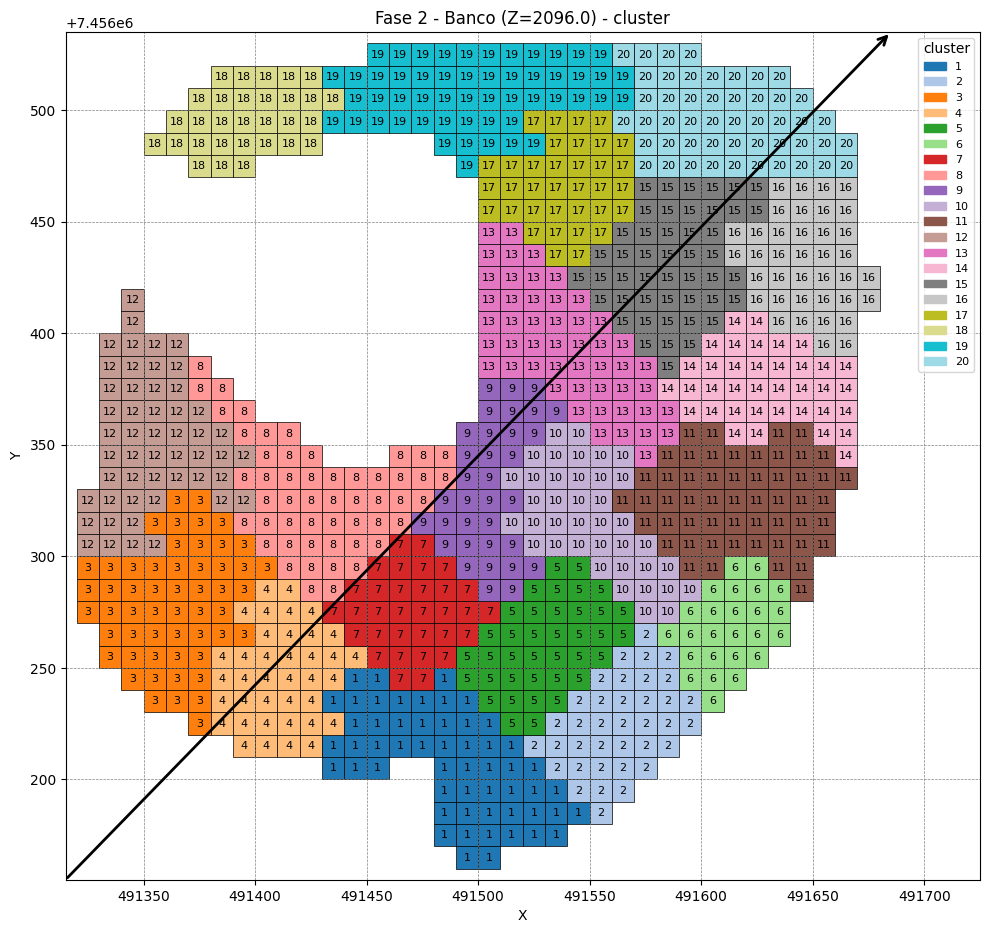

In [17]:
BlockWidth = 10

x_min = np.min(fase_banco['x'].values)-BlockWidth
y_min = np.min(fase_banco['y'].values)-BlockWidth
x_max = np.max(fase_banco['x'].values)+BlockWidth
y_max = np.max(fase_banco['y'].values)+BlockWidth

P1 = (x_min, y_min)
P2 = (x_max, y_max)

adj_matrix = Calculate_Adjency_Matrix(fase_banco, BlockWidth)
sim_matrix = Calculate_Similarity_Matrix(fase_banco, peso_distancia = 3, peso_directional_mining = 0.3, penalizacion_destino = 0.9, penalizacion_roca = 0.5, P_inicio=P1, P_final=P2)

(fase_banco_tabesh, t_agg, N_clusters_agg) = Clustering_Tabesh(fase_banco, adj_matrix, sim_matrix, Average_Desired_Length_Cluster=45, Max_Cluster_Length=55, Debug=False)

plot_fase_banco(fase_banco_tabesh, column_hue='cluster', xsize=10, ysize=10, arrows=[(P1,P2)])

# (fase_banco_tabesh, t_ref, N_cluster_ref) = Shape_Refinement_Tabesh(fase_banco_tabesh, adj_matrix, Min_Cluster_Length=15)

# plot_fase_banco(fase_banco_tabesh, column_hue='cluster', xsize=10, ysize=10)


========PostProcessing Results========
Total de clusters: 20
Tiempo: 0.37575650215148926


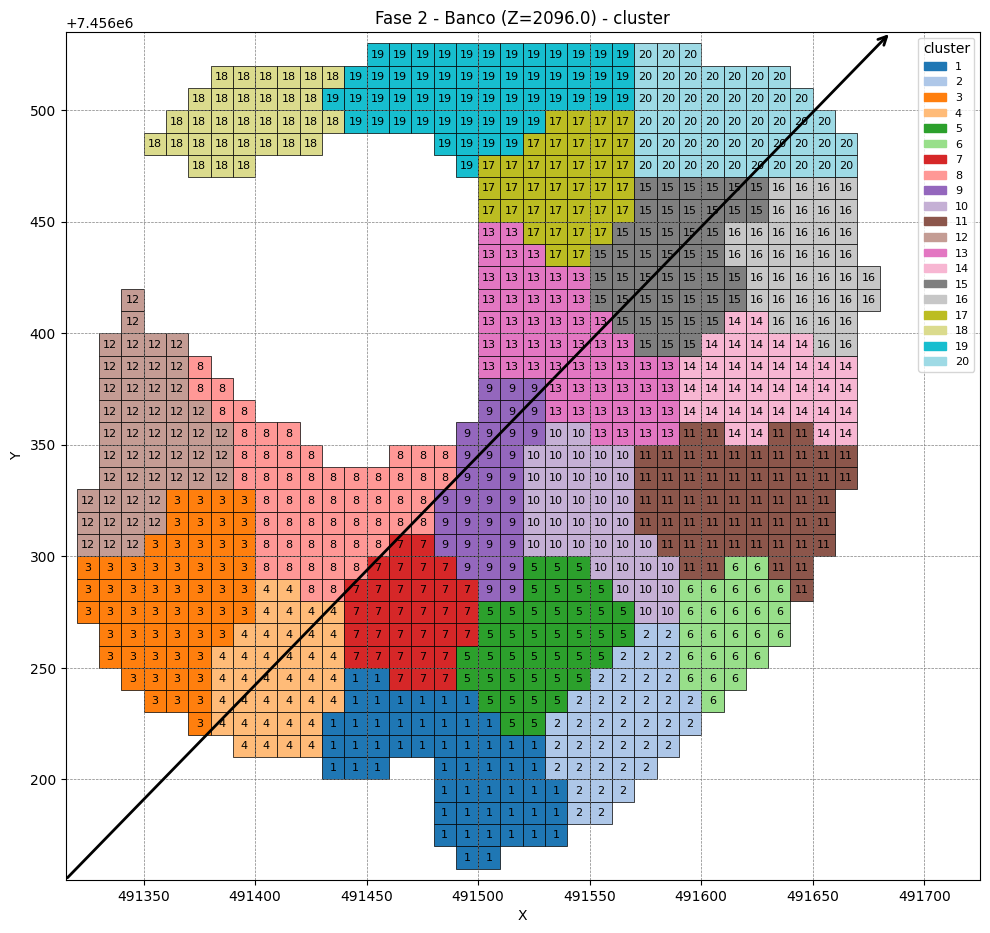

========PostProcessing Results========
Total de clusters: 20
Tiempo: 0.7855751514434814


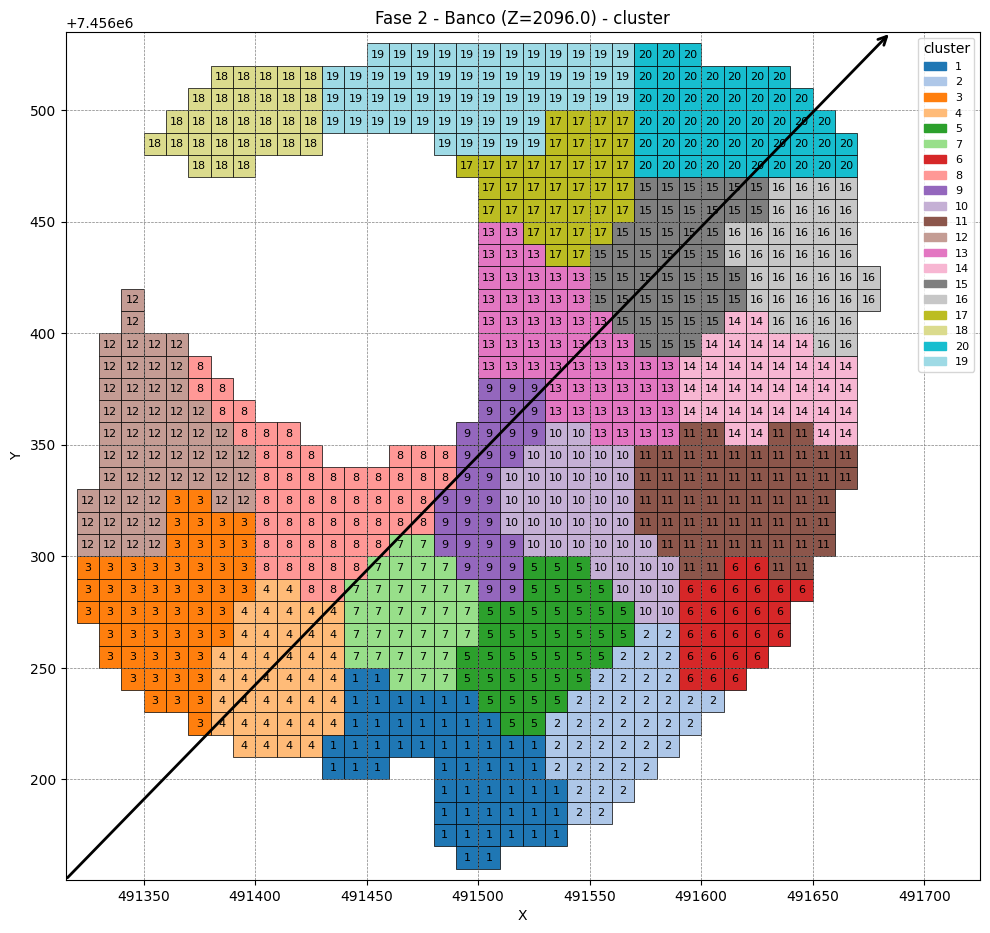

In [18]:
# Comparacion Shape Refinement
(fase_banco_tabesh_shape1, t_ref, N_cluster_ref) = Shape_Refinement_Tabesh(fase_banco_tabesh, adj_matrix, Min_Cluster_Length=15, Iterations_PostProcessing=5)

plot_fase_banco(fase_banco_tabesh_shape1, column_hue='cluster', xsize=10, ysize=10, arrows=[(P1,P2)])

(fase_banco_tabesh_shape2, t_ref, N_cluster_ref) = Shape_Refinement_Mod(fase_banco_tabesh, adj_matrix, Min_Cluster_Length=15,Iterations_PostProcessing=10)

plot_fase_banco(fase_banco_tabesh_shape2, column_hue='cluster', xsize=10, ysize=10, arrows=[(P1,P2)])

========PreProcessing Results========
Tamaño Fase-Banco: 848
Clusters objetivo: 18
Clusters eliminados: 828
Total de clusters: 21
Tiempo: 10.974825143814087


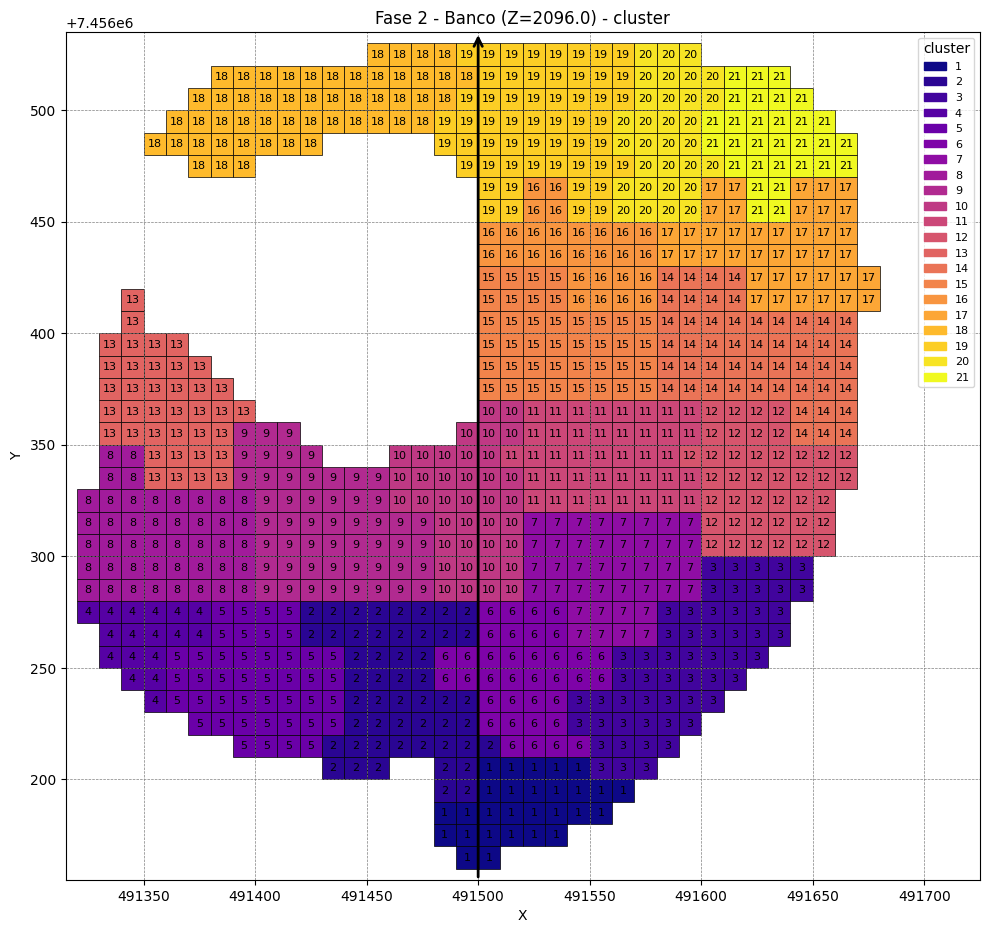

========PostProcessing Results========
Total de clusters: 21
Tiempo: 0.22199225425720215


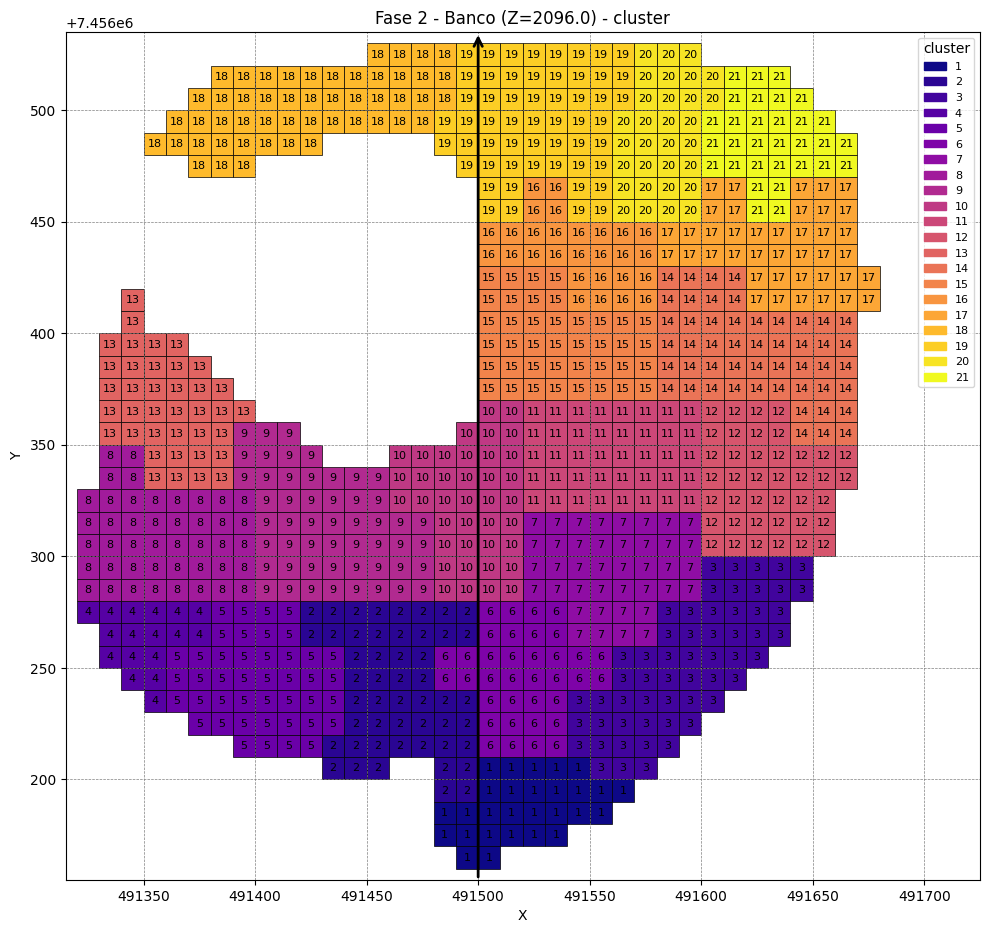

In [19]:
BlockWidth = 10

x_min = np.min(fase_banco['x'].values)-BlockWidth
y_min = np.min(fase_banco['y'].values)-BlockWidth
x_max = np.max(fase_banco['x'].values)+BlockWidth
y_max = np.max(fase_banco['y'].values)+BlockWidth


P1 = ((x_min + x_max)/2, y_min)
P2 = ((x_min + x_max)/2, y_max)

adj_matrix = Calculate_Adjency_Matrix(fase_banco, BlockWidth)
sim_matrix = Calculate_Similarity_Matrix(fase_banco, peso_distancia = 2, peso_directional_mining = 0.1, penalizacion_destino = 0.9, penalizacion_roca = 0.9
, P_inicio=P1, P_final=P2, tol_directional_mining=0.01)


(fase_banco_tabesh_2, t_agg_2, N_clusters_agg_2) = Clustering_Tabesh(fase_banco, adj_matrix, sim_matrix, Average_Desired_Length_Cluster=45, Max_Cluster_Length=55, Debug=False)

plot_fase_banco(fase_banco_tabesh_2, column_hue='cluster', xsize=10, ysize=10, arrows=[(P1,P2)])

(fase_banco_tabesh_2_ref_tab, t_ref_2, N_cluster_ref_2) = Shape_Refinement_Tabesh(fase_banco_tabesh_2, adj_matrix, Min_Cluster_Length=15, Iterations_PostProcessing=10)

plot_fase_banco(fase_banco_tabesh_2_ref_tab, column_hue='cluster', xsize=10, ysize=10, arrows=[(P1,P2)])


========PostProcessing Results========
Total de clusters: 21
Tiempo: 0.7983279228210449


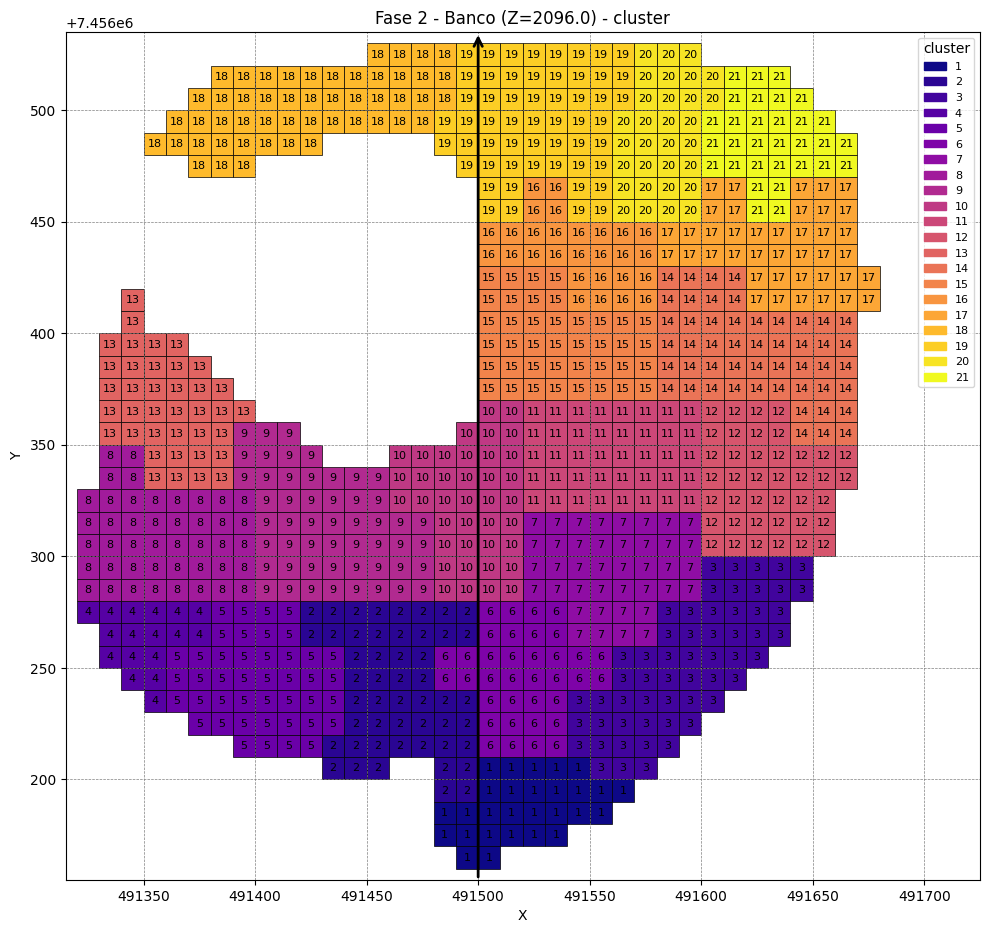

In [20]:
(fase_banco_tabesh_2_ref_mod, t_ref_2, N_cluster_ref_2) = Shape_Refinement_Mod(fase_banco_tabesh_2, adj_matrix, Min_Cluster_Length=15, Iterations_PostProcessing=10)

plot_fase_banco(fase_banco_tabesh_2_ref_mod, column_hue='cluster', xsize=10, ysize=10, arrows=[(P1,P2)])

In [21]:
fase_banco_tabesh

,x,y,z,cut,density,tipomineral,fase,id,destino,cluster
0,491485.0,7456175.0,2096.0,0.366266,2.664827,2,2,11875,1,1
1,491495.0,7456165.0,2096.0,0.366266,2.664827,2,2,11897,1,1
2,491505.0,7456165.0,2096.0,0.361008,2.635160,2,2,11898,1,1
3,491495.0,7456175.0,2096.0,0.366266,2.664827,2,2,11900,1,1
4,491505.0,7456175.0,2096.0,0.361008,2.635160,2,2,11901,1,1
...,...,...,...,...,...,...,...,...,...,...
843,491585.0,7456525.0,2096.0,0.320002,2.627140,2,2,18136,1,20
844,491595.0,7456525.0,2096.0,0.333264,2.627140,2,2,18137,1,20
845,491615.0,7456515.0,2096.0,0.325422,2.611589,2,2,18160,1,20
846,491625.0,7456515.0,2096.0,0.275878,2.619996,2,2,18161,1,20


### Creación Automática de Precedencias por Dirección de Minería

In [ ]:
def Precedencias_Clusters_1(FaseBanco, P_inicio, P_final):
    ID_Clusters = FaseBanco['cluster'].unique()
    Distancias_Clusters = {}
    for id in ID_Clusters:
        Cluster = FaseBanco.loc[FaseBanco['cluster']==id]
        P_center = (Cluster['x'].mean(), Cluster['y'].mean())
        di = np.sqrt( (P_inicio[0] - P_center[0])**2 + (P_inicio[1] - P_center[1])**2 )
        df = np.sqrt( (P_final[0] - P_center[0])**2 + (P_final[1] - P_center[1])**2 )
        L = np.sqrt( (P_inicio[0] - P_final[0])**2 + (P_inicio[1] - P_final[1])**2 )
        D = (di**2 + L**2 - df**2)/(2*L)
        Distancias_Clusters[id] = (D, P_center)
    
    Clusters_Ordenados = sorted(Distancias_Clusters.items(), key=lambda item: item[1])
    Clusters_Ordenados = dict(Clusters_Ordenados)
    return Clusters_Ordenados

def Precedencias_Clusters_2(FaseBanco, P_inicio):
    ID_Clusters = FaseBanco['cluster'].unique()
    Distancias_Clusters = {}
    for id in ID_Clusters:
        Cluster = FaseBanco.loc[FaseBanco['cluster']==id]
        P_center = (Cluster['x'].mean(), Cluster['y'].mean())
        di = np.sqrt( (P_inicio[0] - P_center[0])**2 + (P_inicio[1] - P_center[1])**2 )
        Distancias_Clusters[id] = (di, P_center)
    
    Clusters_Ordenados = sorted(Distancias_Clusters.items(), key=lambda item: item[1])
    Clusters_Ordenados = dict(Clusters_Ordenados)
    return Clusters_Ordenados

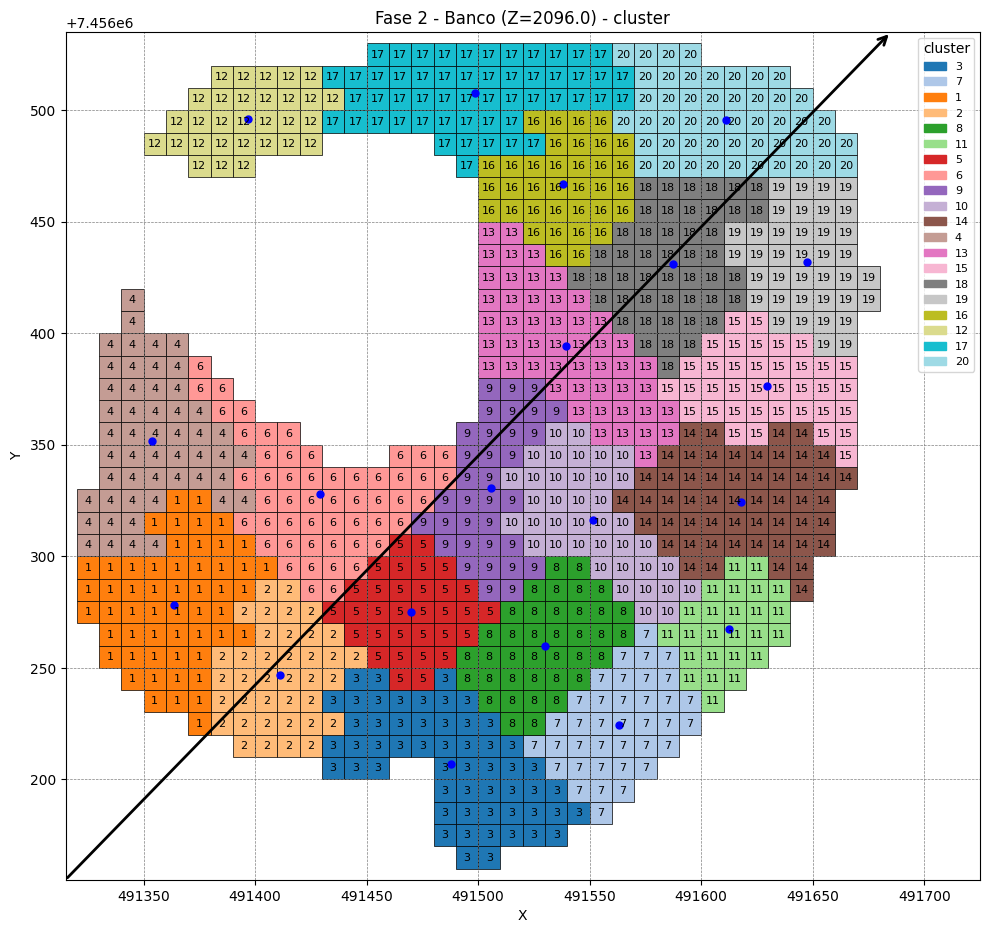

In [90]:
BlockWidth = 10

x_min = np.min(fase_banco['x'].values)-BlockWidth
y_min = np.min(fase_banco['y'].values)-BlockWidth
x_max = np.max(fase_banco['x'].values)+BlockWidth
y_max = np.max(fase_banco['y'].values)+BlockWidth

P1 = (x_min, y_min)
P2 = (x_max, y_max)

P = Precedencias_Clusters_1(fase_banco_tabesh, P1, P2)

Orden_Clusters = np.array(tuple(P.keys()))
Centers = []
for value in P.values():
    Centers.append(value[1])

fb1 = fase_banco_tabesh.copy()
fb1['cluster'] = fb1['cluster'].apply(lambda x: np.where(Orden_Clusters==x)[0][0]+1)
plot_fase_banco(fb1, column_hue='cluster', xsize=10, ysize=10, points=Centers, arrows=[(P1,P2)])

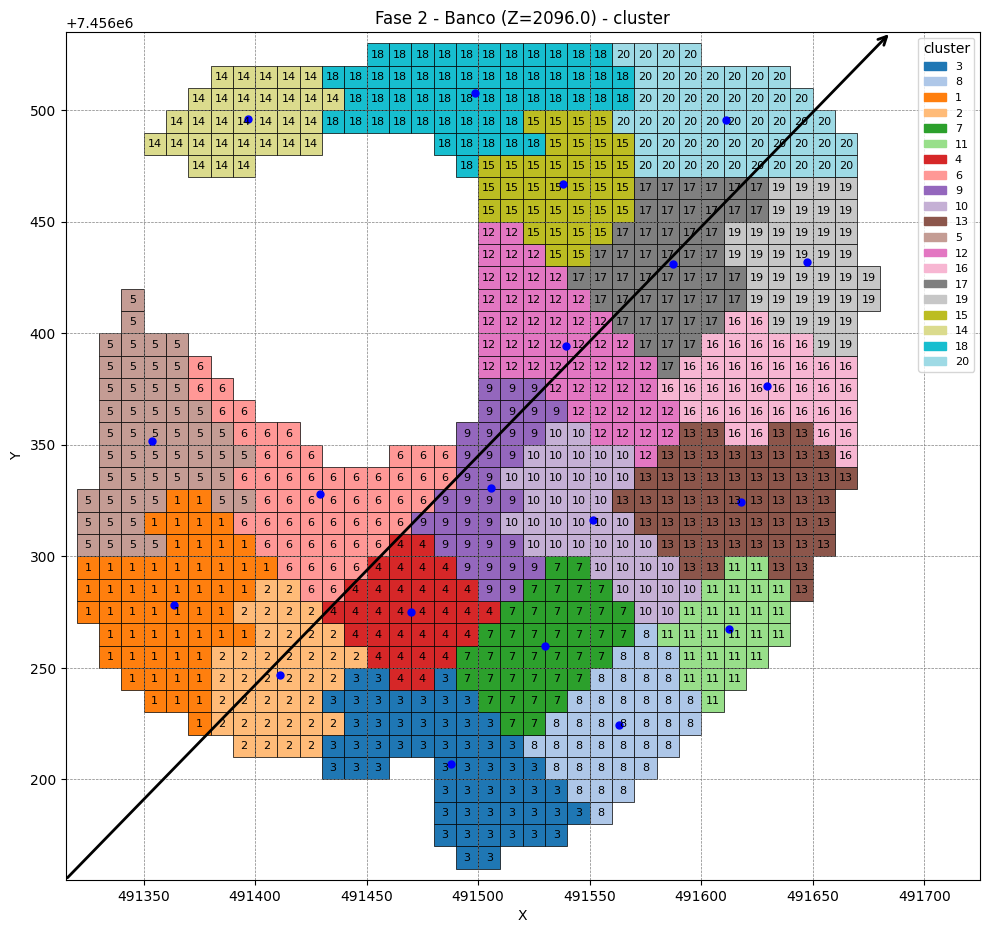

In [ ]:
BlockWidth = 10

x_min = np.min(fase_banco['x'].values)-BlockWidth
y_min = np.min(fase_banco['y'].values)-BlockWidth
x_max = np.max(fase_banco['x'].values)+BlockWidth
y_max = np.max(fase_banco['y'].values)+BlockWidth

P1 = (x_min, y_min)
P2 = (x_max, y_max)

P = Precedencias_Clusters_2(fase_banco_tabesh, P1)

Orden_Clusters2 = np.array(tuple(P.keys()))
Centers = []
for value in P.values():
    Centers.append(value[1])

fb2 = fase_banco_tabesh.copy()
fb2['cluster'] = fb2['cluster'].apply(lambda x: np.where(Orden_Clusters2==x)[0][0]+1)
plot_fase_banco(fb2, column_hue='cluster', xsize=10, ysize=10, points=Centers, arrows=[(P1,P2)])

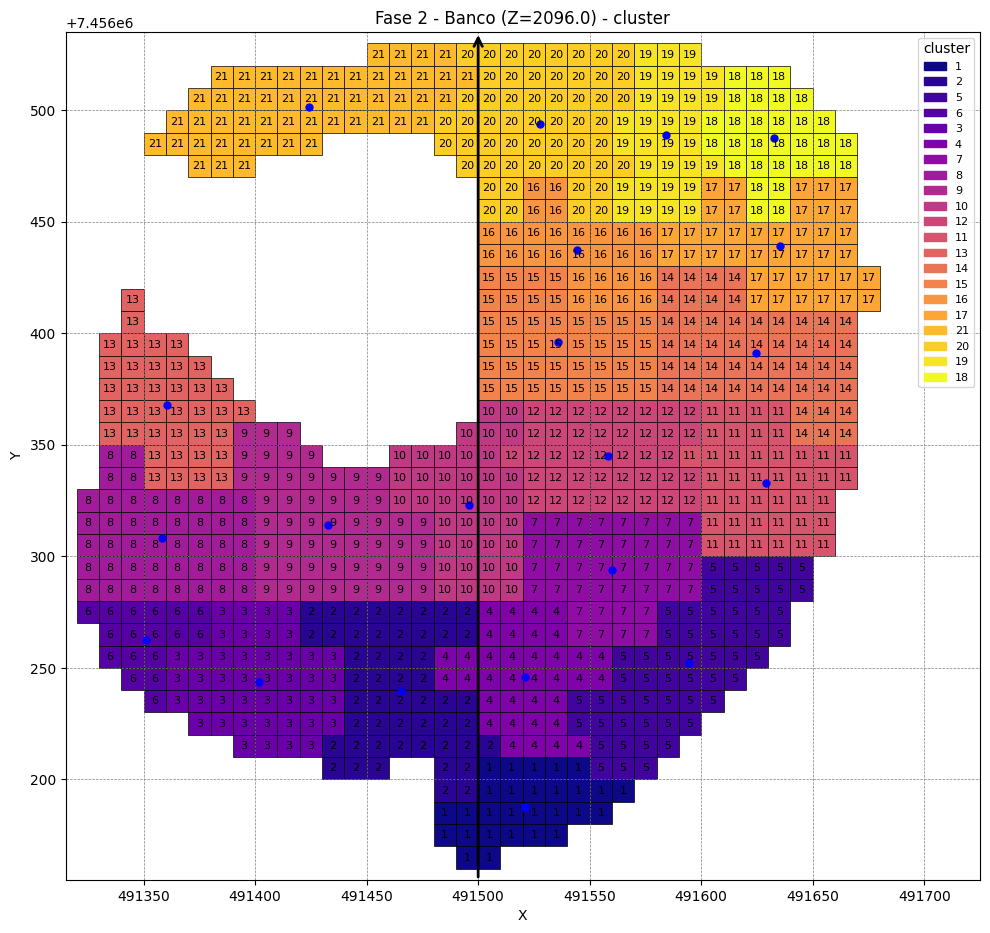

In [92]:
BlockWidth = 10

x_min = np.min(fase_banco['x'].values)-BlockWidth
y_min = np.min(fase_banco['y'].values)-BlockWidth
x_max = np.max(fase_banco['x'].values)+BlockWidth
y_max = np.max(fase_banco['y'].values)+BlockWidth


P1 = ((x_min + x_max)/2, y_min)
P2 = ((x_min + x_max)/2, y_max)

P = Precedencias_Clusters_1(fase_banco_tabesh_2, P1, P2)

Orden_Clusters3 = np.array(tuple(P.keys()))
Centers = []
for value in P.values():
    Centers.append(value[1])

fb3 = fase_banco_tabesh_2.copy()
fb3['cluster'] = fb3['cluster'].apply(lambda x: np.where(Orden_Clusters3==x)[0][0]+1)
plot_fase_banco(fb3, column_hue='cluster', xsize=10, ysize=10, points=Centers, arrows=[(P1,P2)])

### Métricas

In [ ]:
# Definición de métricas globales
def Rock_Unity(FaseBanco):
    ID_Clusters = np.sort(FaseBanco['cluster'].unique())
    num_clusters = len(ID_Clusters)
    sum_rock_unity = 0
    RU_distribution = []
    for id in ID_Clusters:
        Cluster = FaseBanco.loc[FaseBanco['cluster']==id]
        n_cluster = len(Cluster)
        max_rock = Cluster['tipomineral'].value_counts().max()
        ru = max_rock/n_cluster
        sum_rock_unity += ru
        RU_distribution.append(ru)
    RU = sum_rock_unity/num_clusters
    return RU, RU_distribution

def Destination_Dilution_Factor(FaseBanco):
    ID_Clusters = np.sort(FaseBanco['cluster'].unique())
    num_clusters = len(ID_Clusters)
    sum_ddf = 0
    DDF_distribution = []
    for id in ID_Clusters:
        Cluster = FaseBanco.loc[FaseBanco['cluster']==id]
        max_destino = Cluster['destino'].value_counts().idxmax()
        ton_destino = Cluster.loc[Cluster['destino']==max_destino]['density'].sum()
        ton_total = Cluster['density'].sum()
        ddf = ton_destino/ton_total
        sum_ddf += ddf
        DDF_distribution.append(ddf)
    DDF = sum_ddf/num_clusters
    return DDF, DDF_distribution

def Coefficient_Variation(FaseBanco):
    ID_Clusters = np.sort(FaseBanco['cluster'].unique())
    num_clusters = len(ID_Clusters)
    sum_cv = 0
    CV_distribution = []
    for id in ID_Clusters:
        Cluster = FaseBanco.loc[FaseBanco['cluster']==id]
        std = Cluster['cut'].std()
        mean = Cluster['cut'].mean()
        cv = std/mean
        sum_cv += cv
        CV_distribution.append(cv)
    CV = sum_cv/num_clusters
    return CV, CV_distribution


### Clustering withing Boundaries

In [ ]:
Sectores = [( (491300, 150+7.456*10**6), (491480, 150+7.456*10**6), (491480, 420+7.456*10**6), (491300, 420+7.456*10**6) )]

(A, fase_banco_plus, S) = Calculate_Adjency_Matrix(fase_banco, 10, Sectores=Sectores)

In [ ]:
A = Calculate_Adjency_Matrix(fase_banco, 10, Sectores=Sectores)
A

In [ ]:
BlockWidth = 10

x_min = np.min(fase_banco['x'].values)-BlockWidth
y_min = np.min(fase_banco['y'].values)-BlockWidth
x_max = np.max(fase_banco['x'].values)+BlockWidth
y_max = np.max(fase_banco['y'].values)+BlockWidth

P1 = (x_min, y_min)
P2 = (x_max, y_max)

sectores = [( (491300, 150+7.456*10**6), (491480, 150+7.456*10**6), (491480, 420+7.456*10**6), (491300, 420+7.456*10**6) )]

adj_matrix = Calculate_Adjency_Matrix(fase_banco, BlockWidth, Sectores=sectores)
sim_matrix = Calculate_Similarity_Matrix(fase_banco, peso_distancia = 3, peso_directional_mining = 0.3, penalizacion_destino = 0.9, penalizacion_roca = 0.5, P_inicio=P1, P_final=P2)

(fase_banco_tabesh_bound, t_agg_b, N_clusters_agg_b) = Clustering_Tabesh(fase_banco, adj_matrix, sim_matrix, Average_Desired_Length_Cluster=45, Max_Cluster_Length=55, Debug=False)


========PreProcessing Results========
Tamaño Fase-Banco: 848
Clusters objetivo: 18
Clusters eliminados: 830
Total de clusters: 20
Tiempo: 12.066749811172485


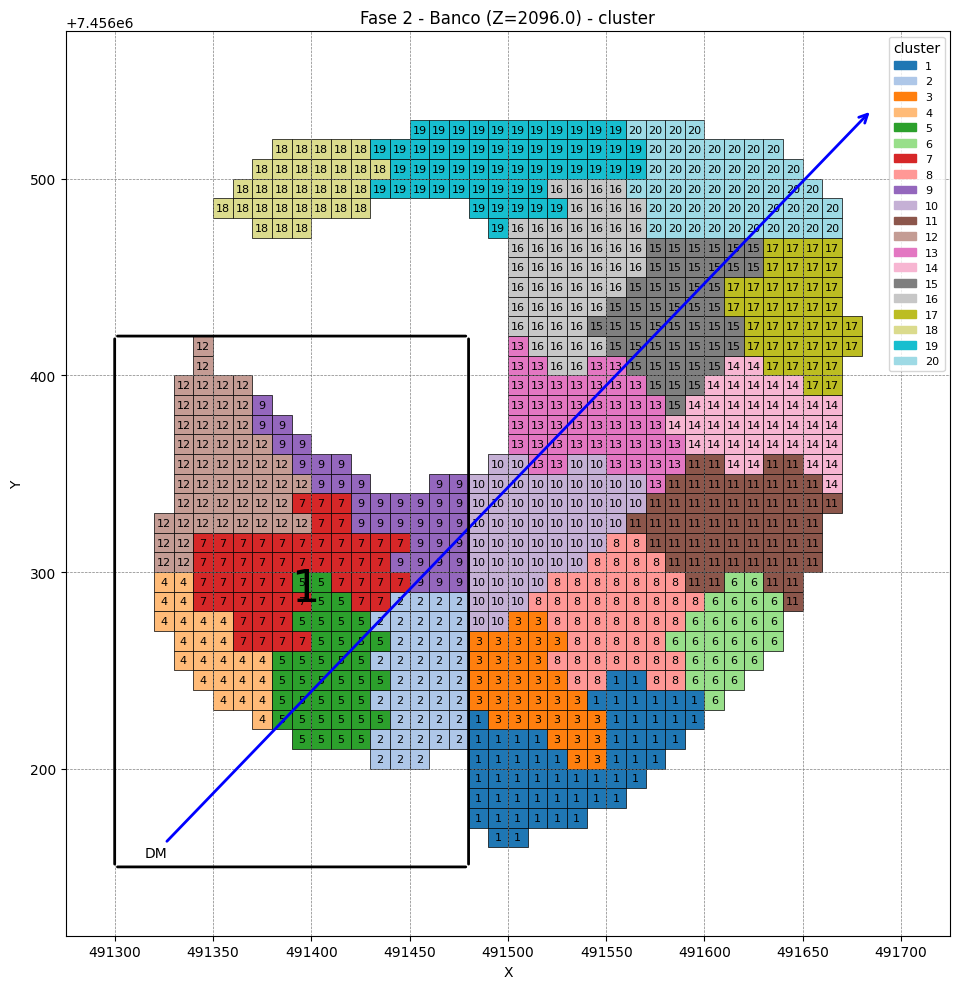

In [105]:
plot_fase_banco(fase_banco_tabesh_bound, column_hue='cluster', xsize=10, ysize=10, arrows=[(P1,P2)], sectors=sectores)

# Clustering de toda la mina

In [22]:
# P = 4
# R = 0.85 
# C_r = 0.25 
# C_m = 2 
# C_p = 10 
# FTL = 2204.62 

# ley_marginal = C_p/((P-C_r)*FTL*R)
# ley_corte = ley_marginal*100

# print(f'Ley de corte usada: {ley_corte}')
# fases = mina_df['fase'].unique()

# Tamaños_fase_banco = []
# Tiempos_clusterizacion_fase_banco = []

# mina_clusterizada = None
# contador_bancos = 1
# contador_clusters = 0
# for fase in fases:
#     bancos = mina_df[mina_df['fase'] == fase]['z'].unique().copy()
#     for banco in bancos:
#         print(f'\n')
#         print(f'Fase-Banco N° {fase}-{banco}')
#         fase_banco = mina_df[(mina_df['fase'] == fase) & (mina_df['z'] == banco)].copy()
#         fase_banco.reset_index(drop=True, inplace=True)
#         fase_banco['destino'] = [1 if fase_banco.iloc[i]['cut']>= ley_corte else 0 for i in range(len(fase_banco))]
#         Tamaños_fase_banco.append(len(fase_banco))

#         print(f'Tamaño de la fase-banco: {len(fase_banco)}')
#         x_min = np.min(fase_banco['x'].values)-10
#         y_min = np.min(fase_banco['y'].values)-10
#         x_max = np.max(fase_banco['x'].values)+10
#         y_max = np.max(fase_banco['y'].values)+10
#         (fase_banco, n_clusters, execution_time) = ClusteringSalman(fase_banco, Tabesh=True, PostProcessing=True, directional_mining=True, P_inicio=(x_min, y_min), P_final=(x_max, y_max))[0:3]
#         if contador_bancos==1:
#             mina_clusterizada = fase_banco.copy()
#         else:
#             mina_clusterizada = pd.concat([mina_clusterizada, fase_banco], ignore_index=True)

#         contador_bancos +=1
#         contador_clusters += n_clusters

#         Tiempos_clusterizacion_fase_banco.append(execution_time)

# print(f'Clusters creados: {contador_clusters}')


# mina_clusterizada

In [23]:
# mina_clusterizada.to_csv('mina_clusterizada_salman.csv')

In [24]:
# sizes = np.array(Tamaños_fase_banco)
# pd.DataFrame(sizes).to_csv('sizes.csv')

In [25]:
# times = np.array(Tiempos_clusterizacion_fase_banco)
# pd.DataFrame(times).to_csv('times.csv')